This script demonstrates the simulation of a rectangular film of magnetic material
using MicroMagnetic.jl. The film has dimensions 100 nm × 100 nm × 10 nm.
The simulation is divided into two main steps:
1. Relaxing the system to obtain an optimal energy state.
2. Simulating the dynamics of a vortex under an applied current.

In [1]:
using MicroMagnetic
using CairoMakie
using Printf
using DelimitedFiles

@using_gpu()

The system is a rectangular film of magnetic material with dimensions 100 nm × 100 nm × 10 nm.

In [2]:
mesh = FDMesh(; nx=20, ny=20, nz=2, dx=5e-9, dy=5e-9, dz=5e-9);

Initialize a vortex roughly.

In [3]:
function init_fun(i, j, k, dx, dy, dz)
    x = i - 10
    y = j - 10
    r = (x^2 + y^2)^0.5
    if r < 2
        return (0, 0, 1)
    end
    return (y / r, -x / r, 0)
end

init_fun (generic function with 1 method)

## Step 1: Relax the system.
This function relaxes the system into an energy-optimal state using the steepest descent driver.

In [4]:
function relax_system(mesh)
    sim = Sim(mesh; driver="SD", name="std5")

    A = 1.3e-11  # Exchange constant
    Ms = 8e5     # Saturation magnetization
    set_Ms(sim, Ms)
    add_exch(sim, A)  # Exchange length=5.7nm
    add_demag(sim)

    init_m0(sim, init_fun)
    relax(sim; max_steps=10000, save_m_every=-1)

    return sim
end

sim = relax_system(mesh);

[ Info: MicroSim has been created.
[ Info: Exchange has been added.
[ Info: Running Driver : MicroMagnetic.EnergyMinimization{Float64}.
[ Info: max_dmdt is less than stopping_dmdt=0.01 @steps=174, Done!


Plot the magnetization distribution using the plot_m function.

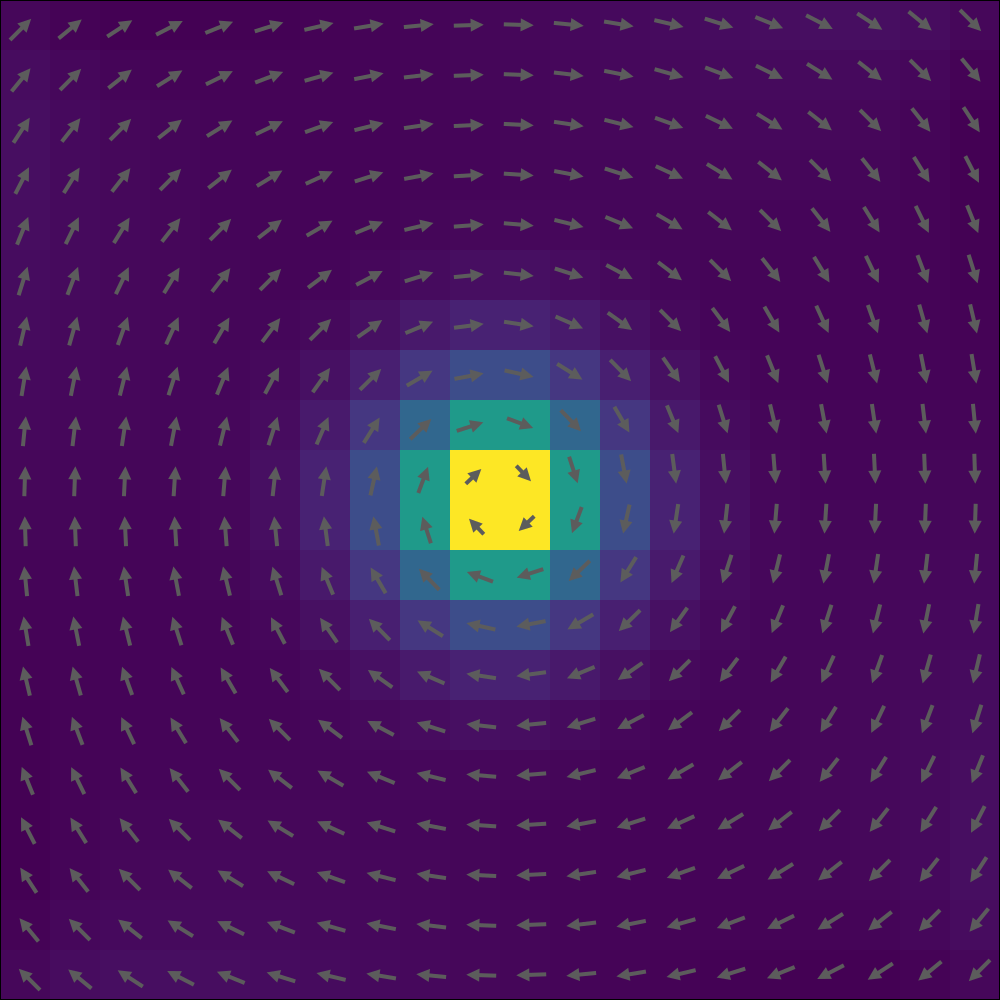

In [5]:
plot_m(sim; component='z')

## Step 2: Vortex Dynamics
This function simulates the dynamics of a vortex under an applied current.

In [6]:
function applied_current(sim, ux, beta)

    set_driver(sim; driver="LLG_STT", alpha=0.1, gamma=2.211e5, beta=beta)
    set_ux(sim, ux)

    fname = "std5_center.txt"
    io = open(fname, "w")
    write(io, "# time(ns)   X(nm)   Y(nm)\n")

    for i in 0:160
        t = i * 5e-11
        run_until(sim, t)

        #Compute the x, y coordinates of the vortex center for layer 1.
        Rx, Ry = MicroMagnetic.compute_guiding_center(sim; z=1)
        write(io, @sprintf("%g   %g   %g\n", t, Rx, Ry))

        if i % 100 == 0
            println("time=", t)
        end
    end
    close(io)
end

applied_current (generic function with 1 method)

Choose a proper current density and run the second step.
$u_x=-Pg \mu_B J/(2eM_s)$
where J=1e12 is the current density, P=1 is the polarization rate,
$g$ is the Lander factor of free electrons, $e$ is the charge of an electron.

In [7]:
if !(isfile("std5_llg_stt.txt") && isfile("std5_center.txt"))
    ux = -72.438
    applied_current(sim, ux, 0.05)
end

Plot the track of vortex center and the three magnetization components.

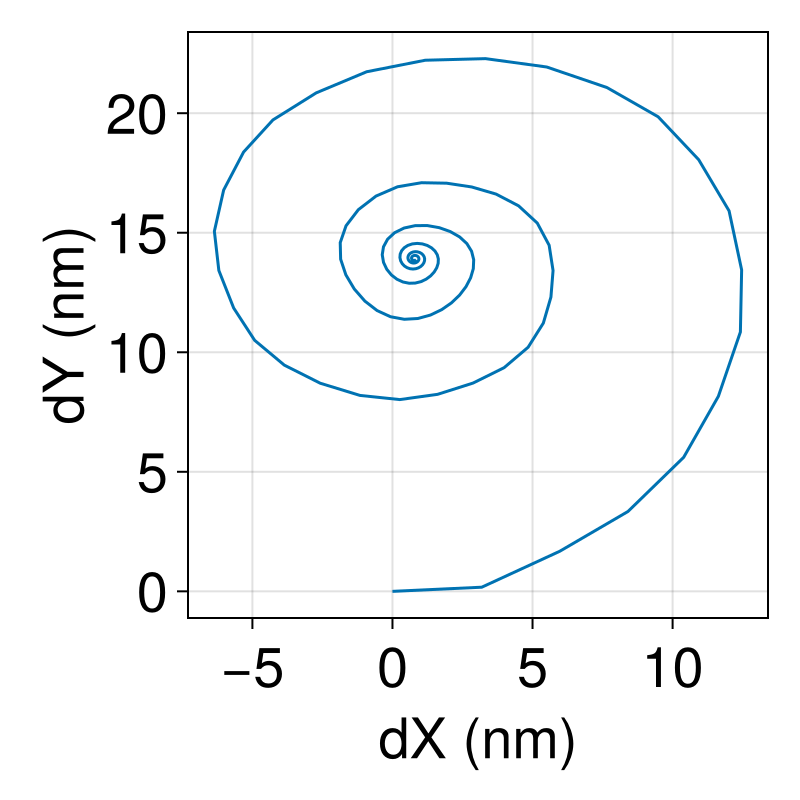

In [8]:
function plot_center()
    data = readdlm("std5_center.txt"; skipstart=1)
    fig = Figure(; size=(400, 400), fontsize=28)
    ax = Axis(fig[1, 1]; xlabel="dX (nm)", ylabel="dY (nm)")
    dX = data[:, 2] .- data[1, 2]
    dY = data[:, 3] .- data[1, 3]
    lines!(ax, dX*1e9, dY*1e9)
    save("assets/std5_center.png", fig)  #Save the plot
    return fig
end

plot_center()

Finally, plot the average magnetization as a function of time.

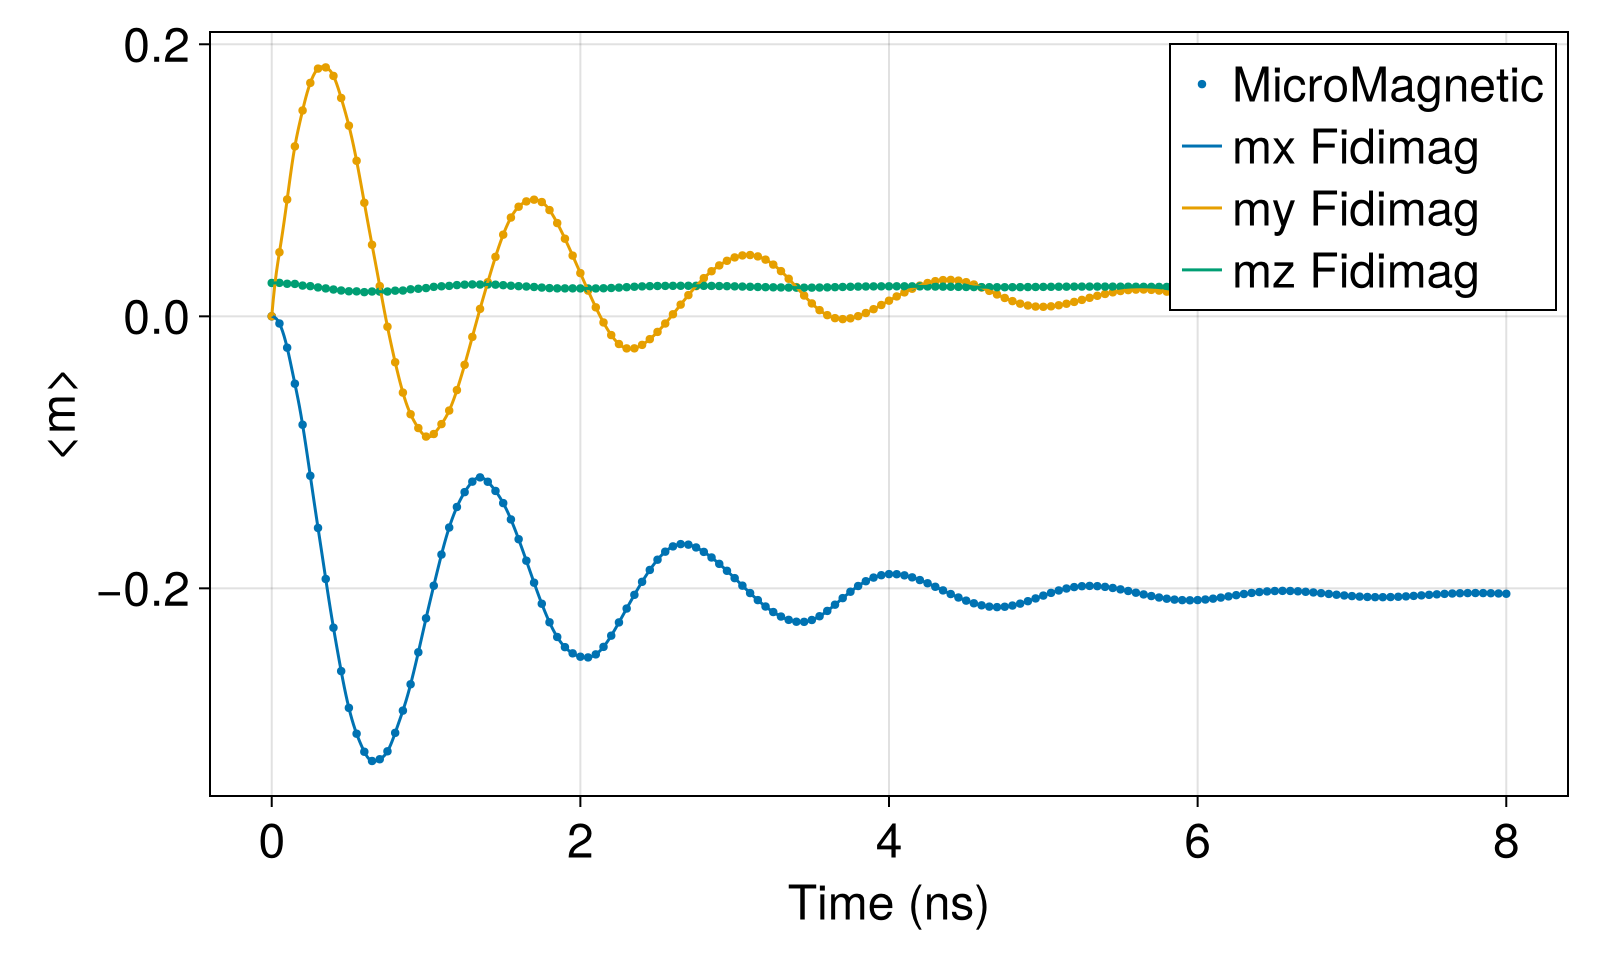

In [9]:
function plot_m_ts()
    data = readdlm("std5_llg_stt.txt"; skipstart=2)
    ts, mx, my, mz = data[:, 2] * 1e9, data[:, 4], data[:, 5], data[:, 6]

    fig = Figure(; size=(800, 480), fontsize=24)
    ax = Axis(fig[1, 1]; xlabel="Time (ns)", ylabel="<m>")
    scatter!(ax, ts, mx; markersize=6, label="MicroMagnetic")
    scatter!(ax, ts, my; markersize=6)
    scatter!(ax, ts, mz; markersize=6)

    #Compare with Fidimag data
    data_fidimag = readdlm("assets/std5_fidimag_data.txt"; skipstart=2)
    ts, mx, my, mz = data_fidimag[:, 1] * 1e9, data_fidimag[:, 5], data_fidimag[:, 6], data_fidimag[:, 7]
    lines!(ax, ts, mx; label="mx Fidimag")
    lines!(ax, ts, my; label="my Fidimag")
    lines!(ax, ts, mz; label="mz Fidimag")

    axislegend()
    save("assets/std5_m.png", fig)  #Save the plot
    return fig
end

plot_m_ts()

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*